In [1]:
# %%
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 7) # make bigger plots

import numpy as np
import pandas as pd
import sklearn.metrics

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA,ARMA

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
%%capture
# create loading bar
from tqdm.notebook import tqdm
tqdm().pandas()

In [4]:
folder = 'C:/Users/Lorenzo/Desktop/MyStuff/Master/Paris/Bloom/data/'

count_ig_csv = folder + 'emerging_risks_doc_count_instagram.csv'
count_tw_csv = folder + 'emerging_risks_doc_count_twitter.csv'
engagement_fb_csv = folder + 'emerging_risks_local_engagement_facebook.csv'
engagement_ig_csv = folder + 'emerging_risks_local_engagement_instagram.csv'
engagement_tw_csv = folder + 'emerging_risks_local_engagement_twitter.csv'
files = [count_ig_csv, count_tw_csv, engagement_fb_csv, engagement_ig_csv, engagement_tw_csv]

In [5]:
# %%
df = pd.read_csv(count_tw_csv)   # twitter has the least number of 0 value data points

try:
    df.drop([381, 382, 383], inplace=True) # drop rows 381, 382, 383 as they are 0 values likely due to errors
    df.date = pd.to_datetime(df.date)
    df.set_index('date', inplace=True)                  # set date as index
    df = df.asfreq('d')
except KeyError:                          # pass if rows 381, 382, 383 have already been dropped
    print("KeyError")
    pass

# Smooth the data

In [6]:
weekly = df.rolling(7).mean()[7:]       # smooth curves with Moving Average(7)

# Example plot: Pesticides VS Smoothed Pesticides

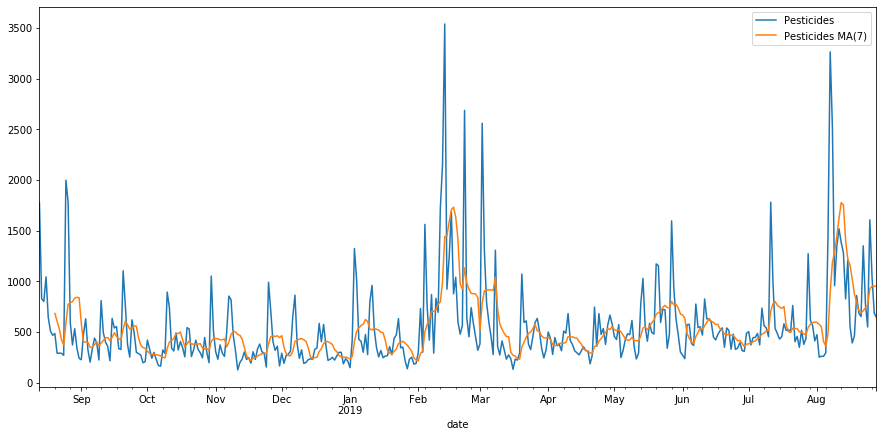

In [7]:
df.Pesticides.plot(label="Pesticides")
weekly.Pesticides.plot(label="Pesticides MA(7)")
plt.legend()

In [8]:
def get_forecast(sarimax_mdl, test: pd.Series, horizon=14, confidence_interval=0.4, plot=False) -> tuple:
    """
    Get forecast of horizon days out of sample for SARIMAX model and return accuracy and width.
    :param test: real time series in test period. MUST start immediately outside train period of sarimax_mdl.
    :return : (accuracy, width) accuracy is % of test points in confidence_interval, width is avg width of 
                                    confidence_interval.
    """
    fcast = sarimax_mdl.get_forecast(horizon).summary_frame(alpha=1 - confidence_interval)    
    prediction = fcast['mean']
    
    # replace negative values with 0 because they are impossible
    fcast['mean_ci_lower'] = [x if x>=0 else 0 for x in fcast['mean_ci_lower']]
    fcast['mean_ci_upper'] = [x if x>=0 else 0 for x in fcast['mean_ci_upper']]
    
    accuracy = 0
    for i, el in enumerate(test):
        if el >= fcast['mean_ci_lower'][i] and el <= fcast['mean_ci_upper'][i]:
            accuracy += 1
    accuracy = accuracy / horizon
    
    width = (fcast['mean_ci_upper'] - fcast['mean_ci_lower']).mean()
    
    if len(fcast) != len(test):
        raise TypeError(f"test and forecast must have same length, test has length {len(test)} and forecast has length "
                        f" {len(fcast)} instead. "
                        "Call get_forecast(horizon=int) to set a different horizon or slice test.")
    
    if plot is True:
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # Plot the data (here we are subsetting it to get a better look at the forecasts)
        test.plot(ax=ax, label=f"{test.name}")

        # Construct the forecasts
        prediction.plot(ax=ax, style='k--', label="Forecast")
        ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1, 
                        label=f"{int(confidence_interval*100)}% Conf Interval")
        plt.legend(loc="lower left")
    
    return accuracy, width

In [9]:
def get_dict_avg(dictionary):
    return sum(dictionary.values())/(len(dictionary.keys()))

# Test get_forecast

In [10]:
test_SARIMAX_model = SARIMAX(weekly.Pesticides[:230], order=(7, 0, 4)).fit()

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Accuracy: 0.8
Width: 360.06977569981956


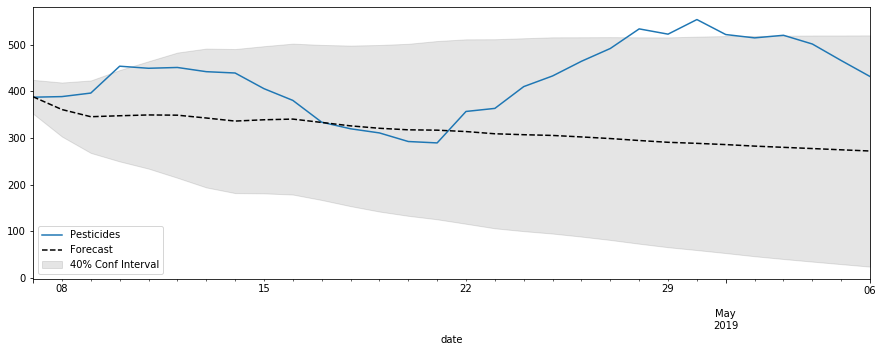

In [11]:
h_test = 30
a = get_forecast(test_SARIMAX_model, weekly.Pesticides[230:230+h_test], horizon=h_test, plot=True)
print("Accuracy:", a[0])
print("Width:", a[1])

# Build the models
Statsmodels SARIMAX outperformed every other model (ARMA, ARIMA, ARIMAX, R forecast autoarima and arima)

In [12]:
# This cell takes 2 mins. Dict comprehension needed to make it faster.

# Create dict with column names and respective models. The models are trained until train_per in order to find best
# coefficients.

def sarimaxing(ser):
    """
    Handle LinAlgError when calculating SARIMAX.
    """
    try:
        result = SARIMAX(ser, order=(7, 0, 4)).fit()
    except np.linalg.LinAlgError:
        # initialization='approximate_diffuse' is required for some corner scenarios when changing the train_per makes the 
        # train time series not stationary, as approximate_diffuse does not assume a stationary distribution 
        # (Source: https://github.com/statsmodels/statsmodels/issues/5459).
        # It is not used by default because accuracy and width are worse (even though by less than 1%)
        warnings.warn(f"LinAlgError detected, discarding stationarity assumption for {ser.name} and running SARIMAX again.")
        result = SARIMAX(ser, order=(7, 0, 4), initialization='approximate_diffuse').fit()
    return result


train_per = int(5/6 * len(weekly))  # train model only until train_per
models = {col: sarimaxing(weekly[col][:train_per]) for col in tqdm(weekly.columns)}

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


# Analyze Forecast Out of Sample

In [13]:
# analyze forecast 14 days out of sample
h = 14

In [21]:
accuracies_h14_ci50 = dict()
widths_h14_ci50 = dict()

for k, v in models.items():
    fc = get_forecast(v, weekly[k][train_per: train_per+h], horizon=h, confidence_interval=0.5, plot=False)
    accuracies_h14_ci50[k] = fc[0]
    widths_h14_ci50[k] = fc[1]

accuracies_h14_ci75 = dict()
widths_h14_ci75 = dict()

for k, v in models.items():
    fc = get_forecast(v, weekly[k][train_per: train_per+h], horizon=h, confidence_interval=0.75, plot=False)
    accuracies_h14_ci75[k] = fc[0]
    widths_h14_ci75[k] = fc[1]

accuracies_h14_ci90 = dict()
widths_h14_ci90 = dict()

for k, v in models.items():
    fc = get_forecast(v, weekly[k][train_per: train_per+h], horizon=h, confidence_interval=0.90, plot=False)
    accuracies_h14_ci90[k] = fc[0]
    widths_h14_ci90[k] = fc[1]

In [15]:
# analyze forecast 28 days out of sample
h = 28

In [16]:
accuracies_h28_ci50 = dict()
widths_h28_ci50 = dict()

for k, v in models.items():
    fc = get_forecast(v, weekly[k][train_per: train_per+h], horizon=h, confidence_interval=0.5, plot=False)
    accuracies_h28_ci50[k] = fc[0]
    widths_h28_ci50[k] = fc[1]

accuracies_h28_ci75 = dict()
widths_h28_ci75 = dict()

for k, v in models.items():
    fc = get_forecast(v, weekly[k][train_per: train_per+h], horizon=h, confidence_interval=0.75, plot=False)
    accuracies_h28_ci75[k] = fc[0]
    widths_h28_ci75[k] = fc[1]

accuracies_h28_ci90 = dict()
widths_h28_ci90 = dict()

for k, v in models.items():
    fc = get_forecast(v, weekly[k][train_per: train_per+h], horizon=h, confidence_interval=0.90, plot=False)
    accuracies_h28_ci90[k] = fc[0]
    widths_h28_ci90[k] = fc[1]

In [17]:
res14_dict = {"Accuracy": [get_dict_avg(x) for x in (accuracies_h14_ci50, accuracies_h14_ci75, accuracies_h14_ci90)], 
           "Width": [get_dict_avg(x) for x in (widths_h14_ci50, widths_h14_ci75, widths_h14_ci90)]}
res14 = pd.DataFrame(res14_dict, index=["50%", "75%", "90%"
                                       ])
res14.index.name = f"14 dd from day {train_per}"

res14['Accuracy'] = res14['Accuracy'].map("{:.2%}".format)

In [18]:
res14

,Accuracy,Width
14 dd from day 311,,
50%,77.60%,71.465377
75%,88.35%,114.586628
90%,93.62%,157.005378


In [19]:
res28_dict = {"Accuracy": [get_dict_avg(x) for x in (accuracies_h28_ci50, accuracies_h28_ci75, accuracies_h28_ci90)], 
           "Width": [get_dict_avg(x) for x in (widths_h28_ci50, widths_h28_ci75, widths_h28_ci90)]}
res28 = pd.DataFrame(res28_dict, index=["50%", "75%", "90%"])
res28.index.name = f"28 dd from day {train_per}"

res28['Accuracy'] = res28['Accuracy'].map("{:.2%}".format)

In [20]:
res28

,Accuracy,Width
28 dd from day 311,,
50%,75.97%,77.597164
75%,88.49%,125.375040
90%,93.55%,172.724648
